# Customer Segmentation

## Table of Content

* [4 Pre-processing](#4) 
* [5 Clustering](#5)
    * [5.1 KMeans](#5.1)
        * [5.1.1 Without Scaling](#5.1.1)
        * [5.1.2 StandardScaler](#5.1.2)
        * [5.1.3 Logarithmic + cubic root transformation](#5.1.3)
        * [5.1.4 Logarithmic + cubic root transformation + StandardScaler](#5.1.4)
    * [5.2 DBSCAN](#5.2)
* [6 Conclusions](#6)

In [487]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta, date

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

%matplotlib inline

## 4 Pre-processing<a id='4'></a>

In [478]:
# Import clean data from data wrangling and EDA
online = pd.read_csv('..\data\online_clean.csv')
online_RFM = pd.read_csv('..\data\online_RFM.csv')

In [479]:
online = online.drop(columns='Unnamed: 0')
online.head()

,Customer ID,Invoice,InvoiceDate,Price,Quantity,StockCode,Country,Description_rev
0,13085,489434,2009-12-01 07:45:00,6.95,12,85048,United Kingdom,15cm christmas glass ball 20 lights
1,13085,489434,2009-12-01 07:45:00,6.75,12,79323P,United Kingdom,pink cherry lights
2,13085,489434,2009-12-01 07:45:00,6.75,12,79323W,United Kingdom,white cherry lights
3,13085,489434,2009-12-01 07:45:00,2.10,48,22041,United Kingdom,"record frame 7"" single size"
4,13085,489434,2009-12-01 07:45:00,1.25,24,21232,United Kingdom,strawberry ceramic trinket box


In [480]:
online_RFM = online_RFM.drop(columns='Unnamed: 0')
online_RFM = online_RFM.rename(columns={'OverallScore': 'RFM_score'})
online_RFM.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score,Segment
0,13085,157,2,92,0,1459.46,0,2,Low-Value
1,16714,218,2,114,0,1222.24,0,2,Low-Value
2,17984,144,2,242,0,1152.19,0,2,Low-Value
3,16955,184,2,53,0,1072.06,0,2,Low-Value
4,18037,153,2,33,0,167.42,0,2,Low-Value


In [481]:
# extract recency, frequency, and revenue 
online_RFM = online_RFM[['Customer ID', 'Recency', 'Frequency', 'Revenue']]

In [482]:
# calcuate average price and quantity for each customer
price_quantity = online.groupby('Customer ID').agg({'Price': 'mean', 'Quantity': 'mean'})
price_quantity = price_quantity.reset_index()

In [483]:
# generate dataset for clustering
model_input = price_quantity.merge(online_RFM, on='Customer ID', how='left').drop(columns='Customer ID')
model_input.head()

,Price,Quantity,Recency,Frequency,Revenue
0,12.074468,1.127660,325,47,-51.74
1,2.498063,13.364865,1,222,4921.53
2,3.786275,53.215686,74,51,2019.40
3,8.358833,8.994444,18,180,4404.54
4,3.841176,11.588235,309,17,334.40


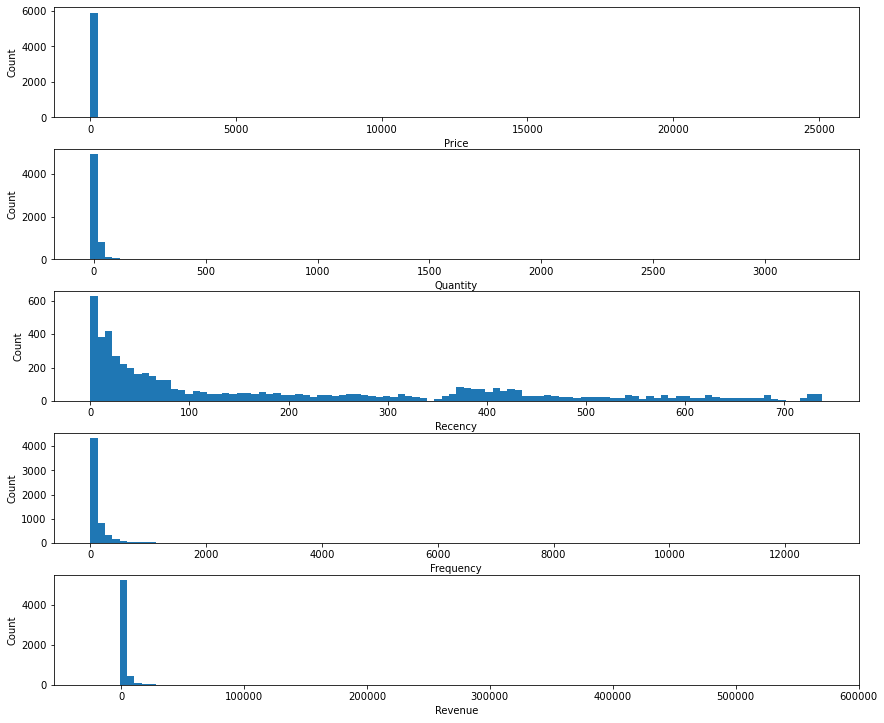

In [484]:
# show the distribution each feature
fig, ax = plt.subplots(5, 1, figsize=(12,10))
fig.tight_layout()

ax[0].hist(model_input['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

- There are some outliers in the dataset.
- There is a huge difference among values of features.
- The skewed features will dramatically affect the performance of clustering. 
- Scaling may be necessary.

## 5 Clustering<a id='5'></a>

### 5.1 KMeans<a id='5.1'></a>

#### 5.1.1 Without Scaling<a id='5.1.1'></a>

**Elbow Method for best number of clusters**

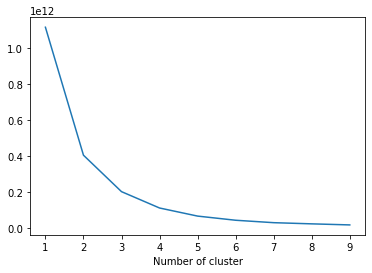

In [485]:
sse={}
# recency = online_recency[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=10).fit(model_input)
#     model_input["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

The elbow method shows that 4 clusters are the best option.

**Silhouette analysis for best number of clusters**

In [489]:
#creating 4 clusters
kmeans = KMeans(n_clusters=4, max_iter=1000)
# kmeans.fit_predict(model_input.iloc[:,1:])
model_input["clusters"] = kmeans.fit_predict(model_input)

#see details of the clusters
cluster_info = model_input.groupby('clusters')['Revenue'].describe()

In [490]:
cluster_info.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,5858.0,1821.652251,2830.594995,-25111.09,317.0125,800.135,2052.270,21535.90
3,71.0,41740.448493,22088.363188,21893.53,25539.2050,33480.820,52250.470,111739.36
2,8.0,195182.235000,62923.301710,124961.98,142827.5300,179256.230,239982.390,296063.44
1,2.0,546861.340000,33261.270611,523342.07,535101.7050,546861.340,558620.975,570380.61


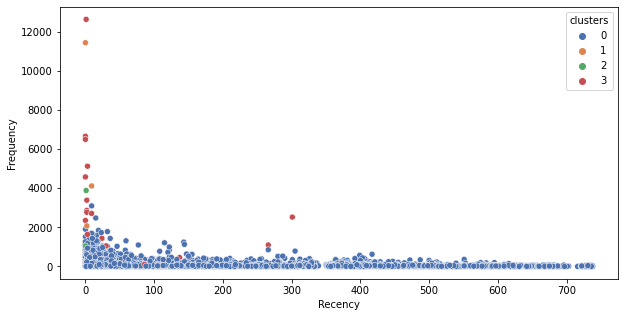

In [419]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.scatterplot(x='Recency', y='Frequency', data=model_input,
               hue='clusters', palette="deep", ax=ax);
# ax.set_ylim(0, 8000)

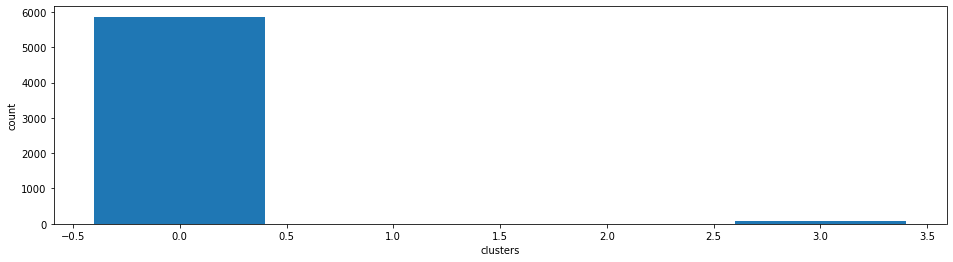

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.bar(cluster_info.index, cluster_info['count'])
ax.set_xlabel('clusters')
ax.set_ylabel('count');

Findings:
- Most of customers fall into clutster 0 and there is one cluster only including 2 customers.
- This clustering doesn't work well. It is possible caused by the skewed features. 

#### 5.1.2 StandardScaler<a id='5.1.2'></a>

In [491]:
model_input=model_input.drop(columns='clusters')

In [492]:
model_input.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,19.835088,18.512167,201.784812,134.334905,2742.884541
std,405.031023,83.275333,211.727459,348.092835,13679.955199
min,0.151333,-16.000000,0.000000,1.000000,-25111.090000
25%,2.323423,5.155944,24.000000,20.000000,321.365000
50%,3.010753,9.075472,95.000000,52.000000,823.530000
75%,3.962383,13.409903,380.000000,140.000000,2143.280000
max,25111.090000,3255.074627,738.000000,12638.000000,570380.610000


In [452]:
scl = StandardScaler()
model_input_std_scale = scl.fit_transform(model_input)
model_input_std_scale = pd.DataFrame(model_input_scale, columns=model_input.columns)
model_input_std_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03
mean,-3.197803e-18,-3.284729e-17,-1.876855e-17,-3.064610e-18,1.109008e-17
std,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00
min,-4.860223e-02,-4.144694e-01,-9.531206e-01,-3.830763e-01,-2.036287e+00
25%,-4.323901e-02,-1.603998e-01,-8.397578e-01,-3.284886e-01,-1.770271e-01
50%,-4.154188e-02,-1.133288e-01,-5.043928e-01,-2.365514e-01,-1.403160e-01
75%,-3.919216e-02,-6.127497e-02,8.417906e-01,1.627604e-02,-4.383458e-02
max,6.195419e+01,3.886907e+01,2.532786e+00,3.592351e+01,4.149762e+01


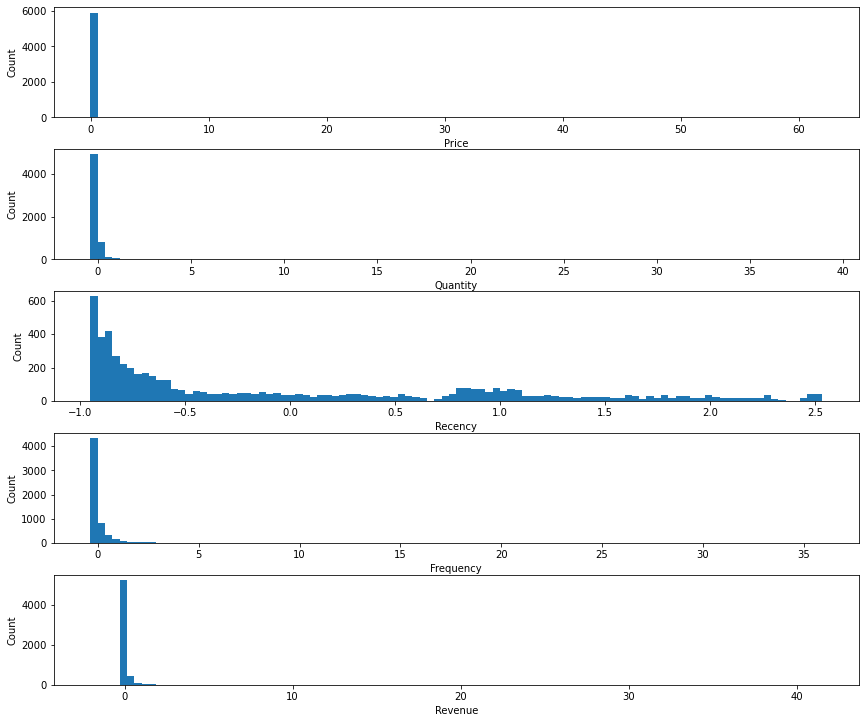

In [424]:
fig, ax = plt.subplots(5, 1, figsize=(12,10))
fig.tight_layout()

ax[0].hist(model_input_std_scale['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input_std_scale['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input_std_scale['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input_std_scale['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input_std_scale['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

- With standard scaler, the difference in the values of features is reduced but the distribution is not changes.

In [425]:
# Redo the clustering
kmeans = KMeans(n_clusters=4,tol=0.000001)
model_input_std_scale["clusters"] = kmeans.fit_predict(model_input_std_scale)

#see details of the clusters
cluster_info = model_input_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,2536.0,-0.354291
1,95.0,-0.786706
2,2214.0,0.792235
3,1094.0,-0.713701


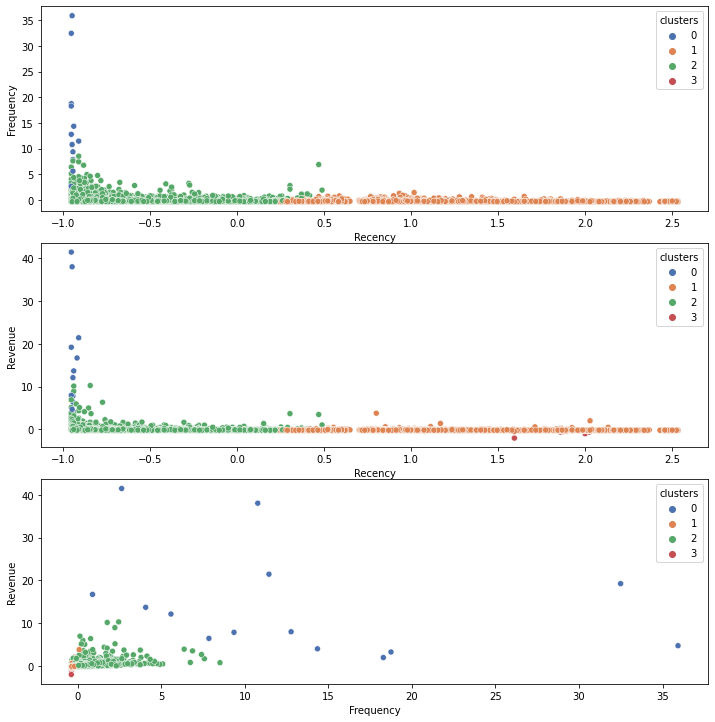

In [426]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_std_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_std_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_std_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)

- The clulstering is improved.
- Recency's contribution is more significant compared to other features.

#### 5.1.3 Logarithmic + cubic root transformation<a id='5.1.3'></a>

In [493]:
model_input_lc_scale = model_input.copy()
model_input_lc_scale[['Price','Frequency']] = np.log(model_input[['Price','Frequency']])
model_input_lc_scale[['Quantity','Revenue']] = np.cbrt(model_input[['Quantity','Revenue']])
model_input_lc_scale['Recency'] = np.cbrt(model_input['Recency'])
model_input_lc_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,1.165223,2.153537,4.897137,3.918763,10.458900
std,0.739563,0.960796,2.391420,1.465930,6.077647
min,-1.888270,-2.519842,0.000000,0.000000,-29.283424
25%,0.843042,1.727572,2.884499,2.995732,6.849615
50%,1.102190,2.085882,4.562903,3.951244,9.373313
75%,1.376846,2.375793,7.243156,4.941642,12.893168
max,10.131065,14.820186,9.036886,9.444463,82.931894


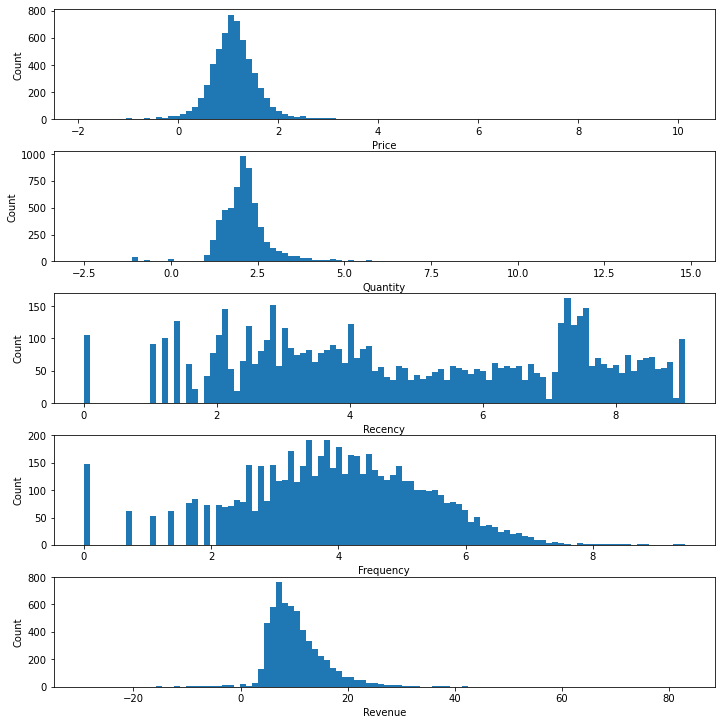

In [494]:
fig, ax = plt.subplots(5, 1, figsize=(10,10))
fig.tight_layout()

ax[0].hist(model_input_lc_scale['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input_lc_scale['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input_lc_scale['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input_lc_scale['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input_lc_scale['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

- Both the values and the distribution of features are changed.

**Silhouette analysis for best number of clusters**

For n_clusters = 2 The average silhouette_score is : 0.4851180700405421
For n_clusters = 3 The average silhouette_score is : 0.3922034590265341
For n_clusters = 4 The average silhouette_score is : 0.35032663939343117
For n_clusters = 5 The average silhouette_score is : 0.3739216245047286


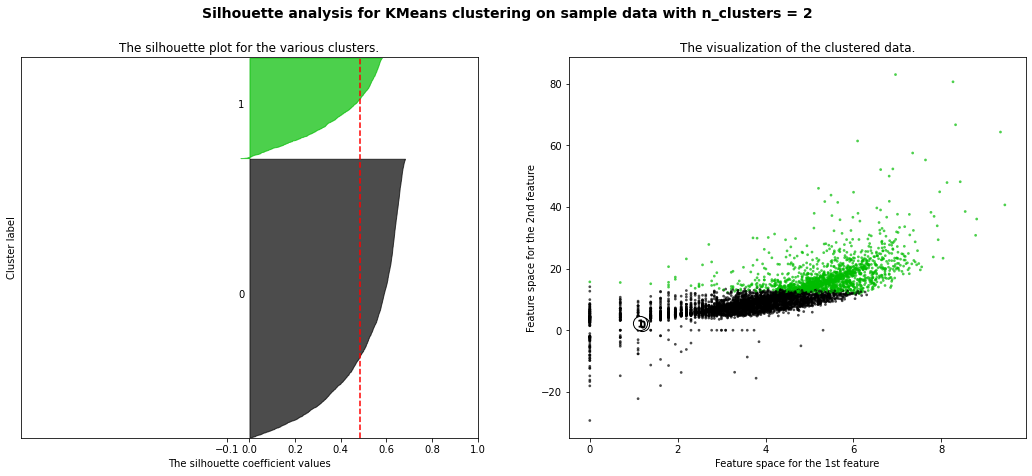

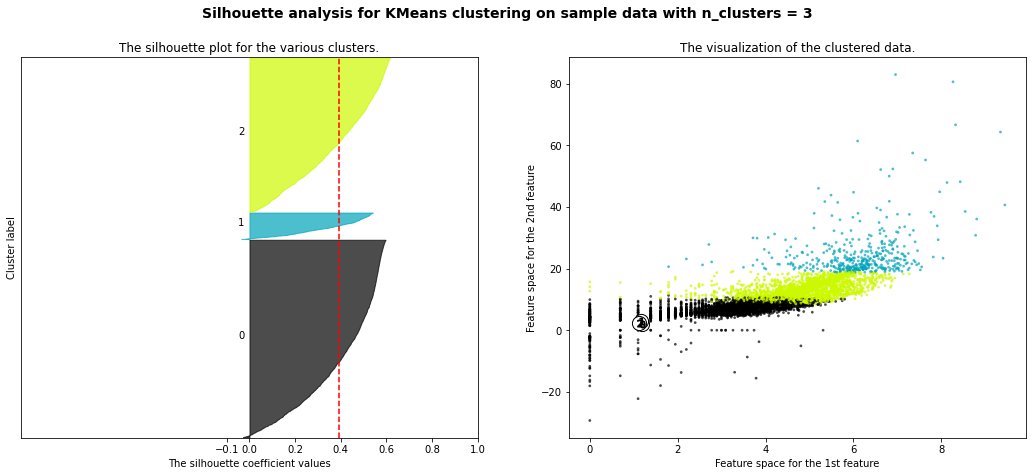

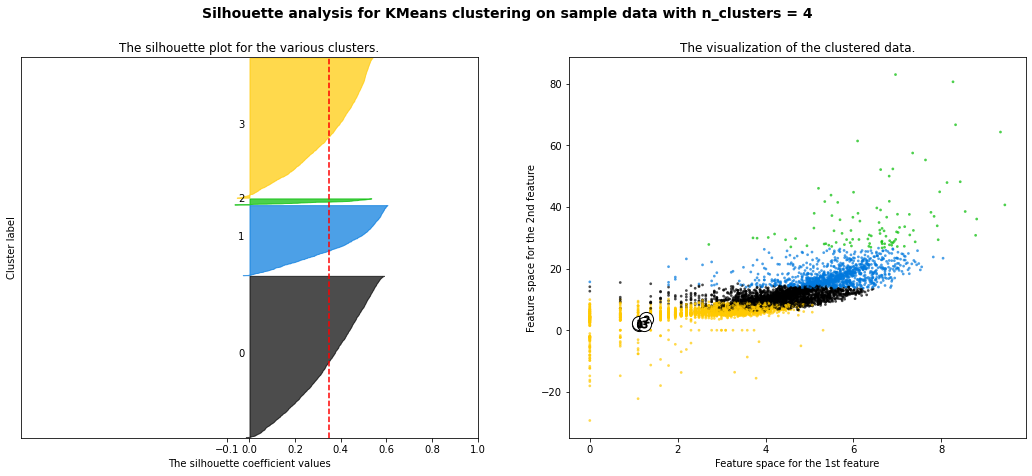

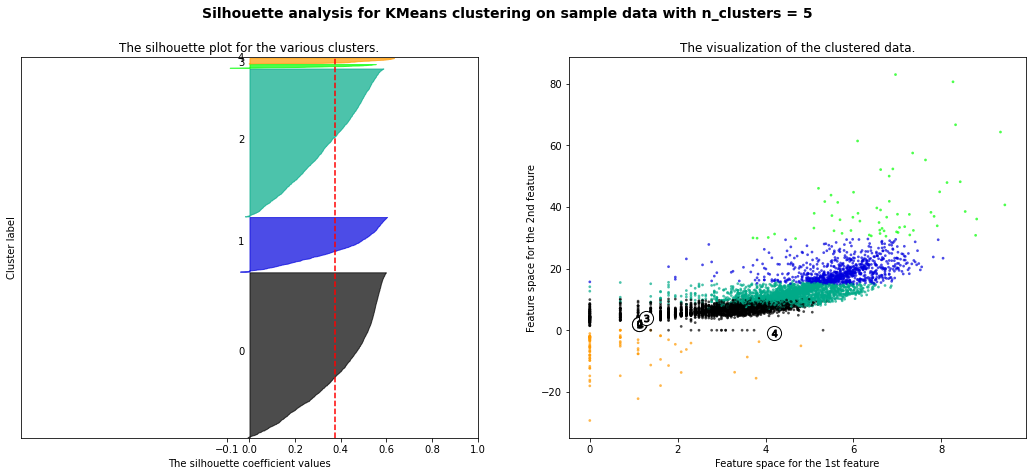

In [511]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1.
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(model_input_lc_scale) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(model_input_lc_scale)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(model_input_lc_scale, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(model_input_lc_scale, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        model_input_lc_scale.iloc[:, 3], model_input_lc_scale.iloc[:, 4], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [526]:
# Redo the clustering
kmeans = KMeans(n_clusters=2,tol=0.000001)
model_input_lc_scale["clusters"] = kmeans.fit_predict(model_input_lc_scale)

#see details of the clusters
cluster_info = model_input_lc_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,4366.0,5.572337
1,1573.0,3.023061


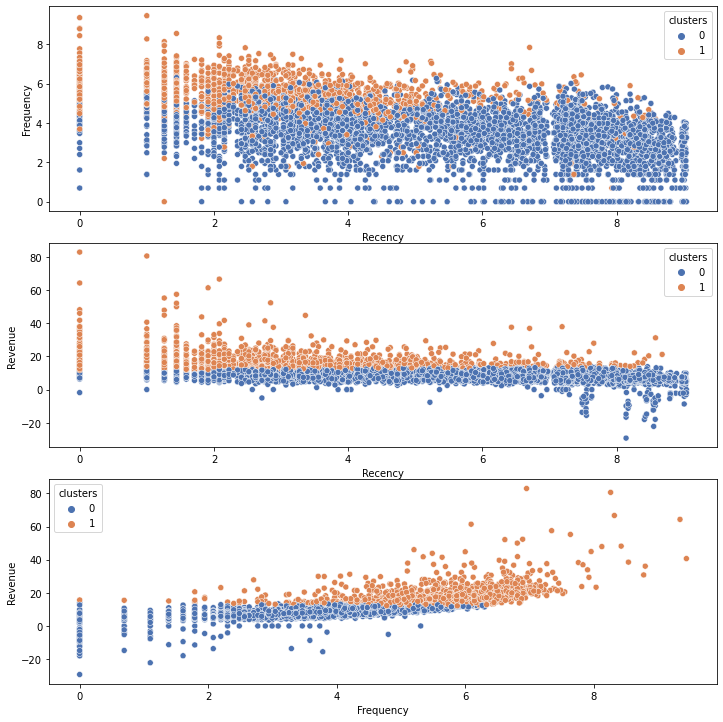

In [527]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_lc_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_lc_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_lc_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)

#### 5.1.4 Logarithmic + cubic root transformation + StandardScaler<a id='5.1.4'></a>

In [520]:
model_input_lc_scale = model_input.copy()
model_input_lc_scale[['Price','Frequency']] = np.log(model_input[['Price','Frequency']])
model_input_lc_scale[['Quantity','Revenue']] = np.cbrt(model_input[['Quantity','Revenue']])
model_input_lc_scale['Recency'] = np.cbrt(model_input['Recency'])
model_input_lc_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,1.165223,2.153537,4.897137,3.918763,10.458900
std,0.739563,0.960796,2.391420,1.465930,6.077647
min,-1.888270,-2.519842,0.000000,0.000000,-29.283424
25%,0.843042,1.727572,2.884499,2.995732,6.849615
50%,1.102190,2.085882,4.562903,3.951244,9.373313
75%,1.376846,2.375793,7.243156,4.941642,12.893168
max,10.131065,14.820186,9.036886,9.444463,82.931894


In [521]:
scl = StandardScaler()
model_input_std_lc_scale = scl.fit_transform(model_input_lc_scale)
model_input_std_lc_scale = pd.DataFrame(model_input_std_lc_scale, columns=model_input_lc_scale.columns)
model_input_std_lc_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03
mean,1.221731e-16,-1.059376e-16,-2.044912e-16,-6.355882e-19,1.349690e-17
std,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00
min,-4.129130e+00,-4.864480e+00,-2.047967e+00,-2.673451e+00,-6.539648e+00
25%,-4.356743e-01,-4.433840e-01,-8.416786e-01,-6.297082e-01,-5.939122e-01
50%,-8.523724e-02,-7.042185e-02,-1.397758e-01,2.215897e-02,-1.786346e-01
75%,2.861694e-01,2.313437e-01,9.810976e-01,6.978269e-01,4.005617e-01
max,1.212419e+01,1.318460e+01,1.731229e+00,3.769733e+00,1.192552e+01


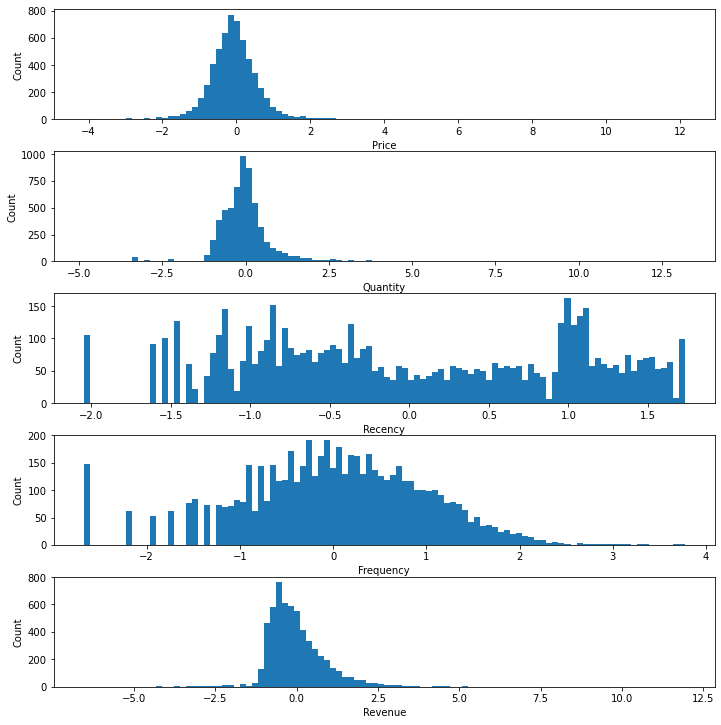

In [522]:
fig, ax = plt.subplots(5, 1, figsize=(10,10))
fig.tight_layout()

ax[0].hist(model_input_std_lc_scale['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input_std_lc_scale['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input_std_lc_scale['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input_std_lc_scale['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input_std_lc_scale['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

**Silhouette analysis for best number of clusters**

For n_clusters = 2 The average silhouette_score is : 0.29763690640840496
For n_clusters = 3 The average silhouette_score is : 0.3100180984612904
For n_clusters = 4 The average silhouette_score is : 0.32151412086109343
For n_clusters = 5 The average silhouette_score is : 0.2600000906675261


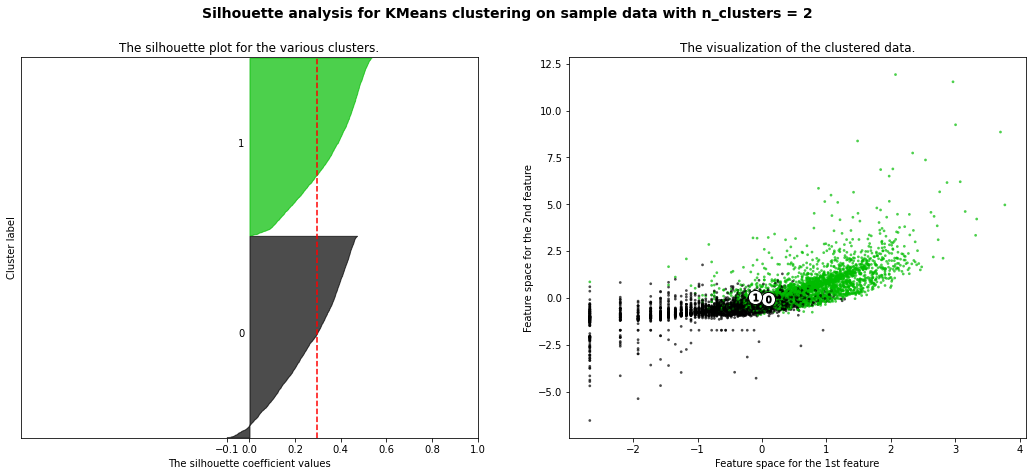

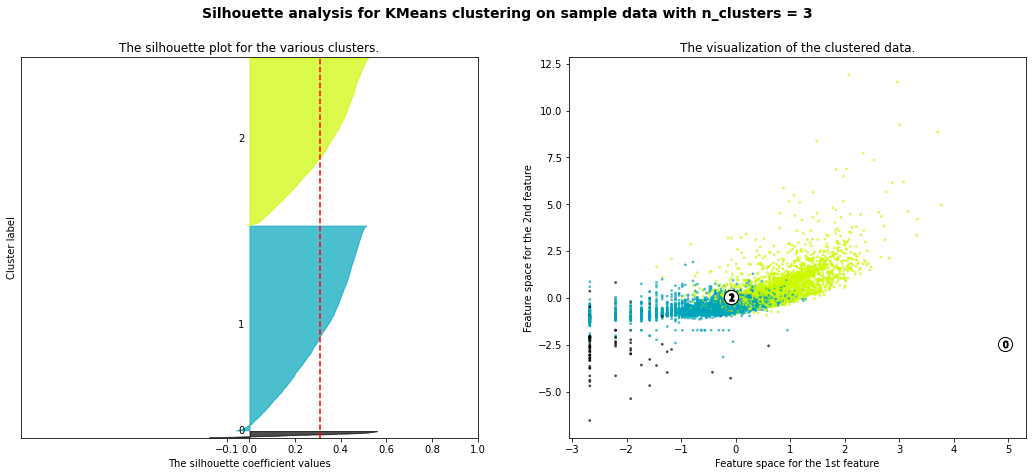

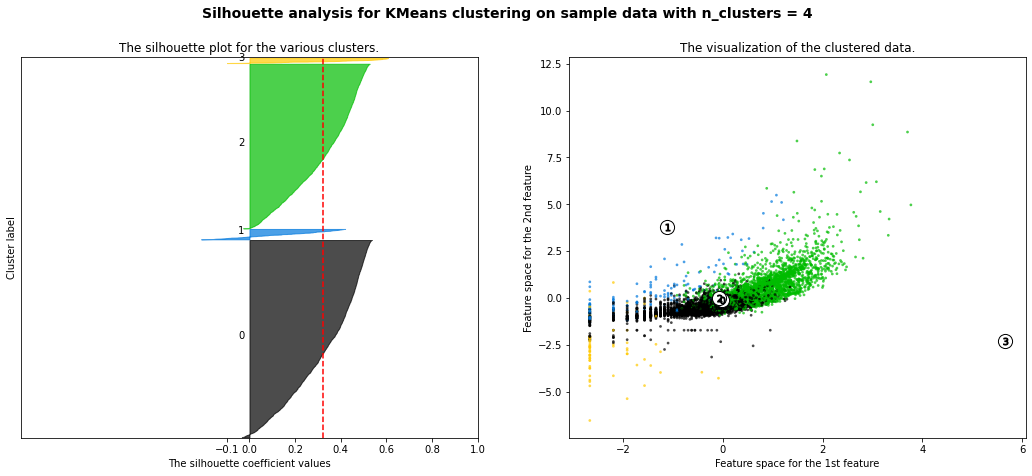

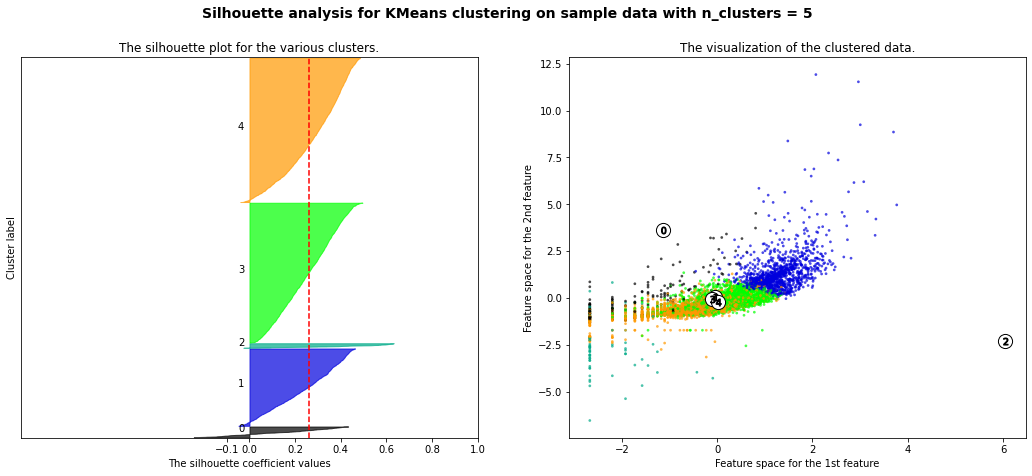

In [523]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1.
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(model_input_std_lc_scale) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(model_input_std_lc_scale)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(model_input_std_lc_scale, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(model_input_std_lc_scale, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        model_input_std_lc_scale.iloc[:, 3], model_input_std_lc_scale.iloc[:, 4], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### 5.2 DBSCAN<a id='5.2'></a>

In [453]:
model_input.head()

,Price,Quantity,Recency,Frequency,Revenue
0,12.074468,1.127660,325,47,-51.74
1,2.498063,13.364865,1,222,4921.53
2,3.786275,53.215686,74,51,2019.40
3,8.358833,8.994444,18,180,4404.54
4,3.841176,11.588235,309,17,334.40


In [476]:
clustering = DBSCAN(eps=1.1, min_samples=1).fit(model_input)
model_input["clusters"] = clustering.labels_

#see details of the clusters
cluster_info = model_input.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,1.0,325.0
1,1.0,1.0
2,1.0,74.0
3,1.0,18.0
4,1.0,309.0
...,...,...
5931,1.0,3.0
5932,1.0,429.0
5933,1.0,660.0


In [439]:
model_input_std_lc_scale = model_input_std_lc_scale.drop(columns='clusters')
model_input_std_lc_scale.head()

,Price,Quantity,Recency,Frequency,Revenue
0,1.792927,-1.158175,0.827280,-0.046811,-2.334189
1,-0.337670,0.228572,-1.629770,1.012353,1.077964
2,0.224691,1.673584,-0.292236,0.008912,0.358873
3,1.295599,-0.076903,-0.951981,0.869278,0.976309
4,0.244159,0.113873,0.779300,-0.740582,-0.578875


In [451]:
clustering = DBSCAN(eps=2, min_samples=5).fit(model_input_std_lc_scale)
model_input_std_lc_scale["clusters"] = clustering.labels_

#see details of the clusters
cluster_info = model_input_std_lc_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
-1,53.0,0.242122
0,5787.0,-0.016140
1,67.0,1.436460
2,5.0,-1.342842
3,7.0,1.183116
4,8.0,-1.788575
5,7.0,0.435869
6,5.0,-1.197126


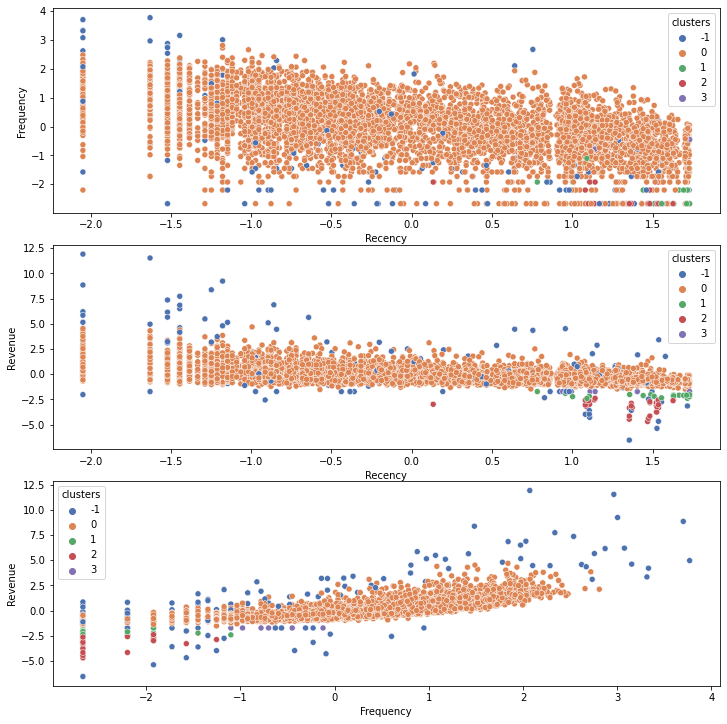

In [449]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)